# Приложение к диплому
Создание, обучение и анализ моделей

** Импортирование библиотек **

In [198]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, classification_report, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
import pylab as plt
import mglearn

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
%matplotlib inline

In [157]:
def learning_curve_model(X, Y, model, cv, train_sizes):
    """Функция строит кривую обучения"""
    plt.figure(figsize=(16, 10))
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")


    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
                     
    plt.legend(loc="best")
    return plt

class NullColumnsCleaner(BaseEstimator, TransformerMixin):
    """Трансформер, который убирает колонки, содержащий большое кол-во пустых значений"""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        nulls = X.isnull().sum()
        nulls_keys = nulls[nulls > 50].keys()
        return X.drop(nulls_keys, axis=1).dropna()

## Чтение данных и первый взгляд

Первые пять строк данных

In [3]:
data = pd.read_excel('Data.xlsm')
data.head()

,"Stroke(AIS,TIA,AHS)",Sex01,StrokeAge,gFGB,gF2,gF5,gF7VII,gF13,gITGA,gITGB,...,gADD1 1378 G>T,gAGT T704C,gAGT C521T,gAGTR1 A 1166C,gAGTR2 G1675A,gCYP11B2 C344T,gGNB3 825C>T,gNOS3 T786C,gNOS3 G894T,DisNeuro01
0,AIS,1,1.0,0,0,0,0.0,1.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0
1,AIS,1,3.0,0,0,0,0.0,0.0,2.0,0.0,...,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0
2,AIS,0,5.0,0,0,0,0.0,1.0,1.0,2.0,...,1.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0
3,AIS,1,0.0,0,0,0,0.0,0.0,2.0,1.0,...,0.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,0
4,AIS,1,13.0,0,0,0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
# Краткое описание данных. Количество признаков, столбцов, типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 25 columns):
Stroke(AIS,TIA,AHS)    154 non-null object
Sex01                  154 non-null int64
StrokeAge              151 non-null float64
gFGB                   154 non-null int64
gF2                    154 non-null int64
gF5                    154 non-null int64
gF7VII                 148 non-null float64
gF13                   148 non-null float64
gITGA                  151 non-null float64
gITGB                  152 non-null float64
gPAI-1                 153 non-null float64
gMTR:2756A>G           148 non-null float64
gMTRR:66A>G            148 non-null float64
gMTHFR677СT            152 non-null float64
gMTHFR:1298A>C         148 non-null float64
gADD1 1378 G>T         71 non-null float64
gAGT T704C             72 non-null float64
gAGT C521T             72 non-null float64
gAGTR1 A 1166C         72 non-null float64
gAGTR2 G1675A          72 non-null float64
gCYP11B2 C344T         72 non

In [5]:
# Стандартное отклонение, среднее, персентели
data.describe()

,Sex01,StrokeAge,gFGB,gF2,gF5,gF7VII,gF13,gITGA,gITGB,gPAI-1,...,gADD1 1378 G>T,gAGT T704C,gAGT C521T,gAGTR1 A 1166C,gAGTR2 G1675A,gCYP11B2 C344T,gGNB3 825C>T,gNOS3 T786C,gNOS3 G894T,DisNeuro01
count,154.000000,151.000000,154.000000,154.000000,154.000000,148.000000,148.000000,151.000000,152.000000,153.000000,...,71.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,81.000000,81.000000,154.000000
mean,0.655844,3.350993,0.577922,0.045455,0.064935,0.162162,0.594595,0.880795,0.388158,1.176471,...,0.577465,0.958333,0.333333,0.486111,1.097222,1.125000,0.541667,1.074074,0.567901,0.474026
std,0.476642,4.650733,0.634338,0.208979,0.272373,0.421433,0.668411,0.692119,0.540411,0.708201,...,0.710372,0.700855,0.530745,0.581234,0.921721,0.710832,0.626583,0.720725,0.650736,0.500954
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,4.500000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000
max,1.000000,17.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000


**Матрица корреляции**

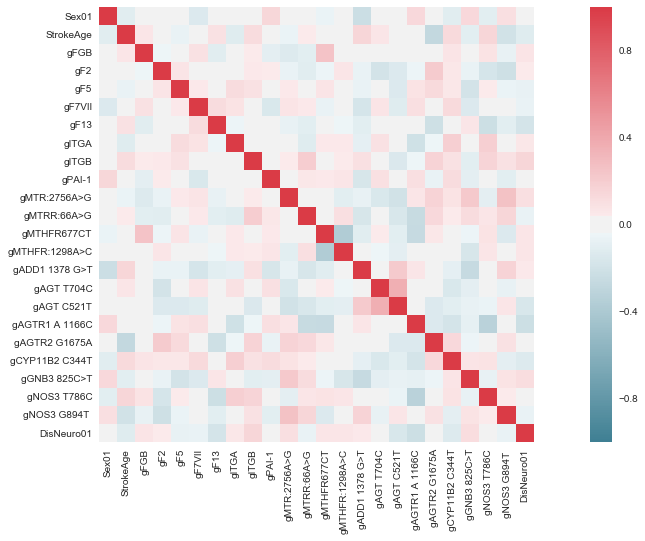

In [6]:
f, ax = plt.subplots(figsize=(20, 8))
corr = data.corr('spearman')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [324]:
corr["DisNeuro01"].sort_values(ascending=False)

DisNeuro01        1.000000
gITGB             0.148790
gGNB3 825C>T      0.113762
gMTR:2756A>G      0.107731
gFGB              0.072636
gMTHFR:1298A>C    0.068079
gMTHFR677СT       0.065608
gITGA             0.059500
gADD1 1378 G>T    0.049230
gF2               0.042567
gNOS3 T786C       0.037769
gAGTR2 G1675A     0.018982
gAGT T704C       -0.022679
Sex01            -0.023996
gPAI-1           -0.028985
gNOS3 G894T      -0.065599
gMTRR:66A>G      -0.066198
gF7VII           -0.070085
gF5              -0.071265
StrokeAge        -0.119893
gCYP11B2 C344T   -0.127977
gAGT C521T       -0.156649
gF13             -0.179711
gAGTR1 A 1166C   -0.223450
Name: DisNeuro01, dtype: float64

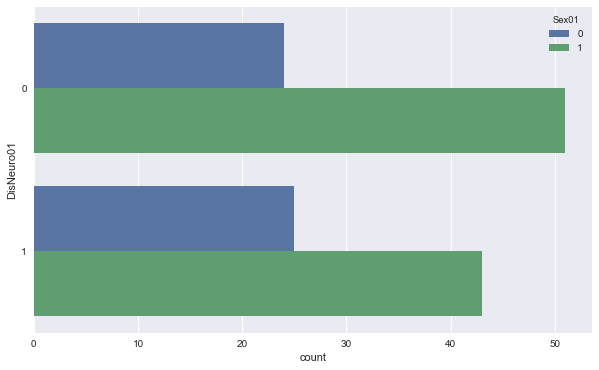

In [451]:
plt.figure(figsize=(10, 6))
sns.countplot(y="DisNeuro01", hue="Sex01", data=data)

** Предварительная подготовка данных. Отчистка и скалирование **

In [348]:
# Убираем колонки
data = NullColumnsCleaner().fit_transform(data).reset_index(drop=True)
# Разбиение на предикаторы и зависимум переменную
X = data.drop(["DisNeuro01",  "Stroke(AIS,TIA,AHS)"], axis=1)
y = data["DisNeuro01"].copy()

# Разбиваем стратифицировано данные на train и test выборки
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    strat_train = data.loc[train_index]
    strat_test = data.loc[test_index]
X_train = strat_train.drop(["DisNeuro01",  "Stroke(AIS,TIA,AHS)"], axis=1)
y_train = strat_train["DisNeuro01"].copy()
X_test = strat_test.drop(["DisNeuro01",  "Stroke(AIS,TIA,AHS)"], axis=1)
y_test = strat_test["DisNeuro01"].copy()

# Добавляем полиминальные признаки и скалируем данные std=1 и median=0, и 
prep_pipe = Pipeline([('poly_feature', PolynomialFeatures(interaction_only=True)), 
                      ('std_scaler', StandardScaler()),]).fit(X_train)
X_train_prep = prep_pipe.transform(X_train)
X_test_prep = prep_pipe.transform(X_test)

**Логистическая регрессия**

Score:  0.760869565217 Test score:  0.620689655172 Best params:  {'C': 1, 'penalty': 'l1'}


<module 'pylab' from '/home/user/Desktop/machine_learning/myvenv/lib/python3.6/site-packages/pylab.py'>

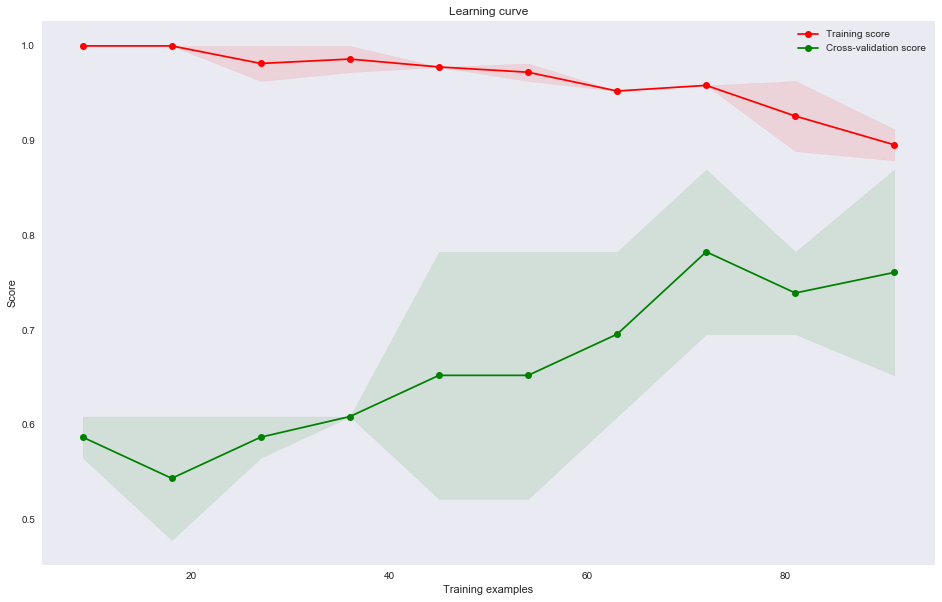

In [350]:
# Используем для подбора параметров кросс-валидацию
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
# Ищем наилучшие гиперпараметры для логистической регрессии(степень и уровнь регуляризации)
grid_search = GridSearchCV(LogisticRegression(), {"C": [0.001, 0.01, 0.1, 1, 3, 5, 10, 100, 500, 1000], "penalty": ["l2", "l1"]}, cv=cv)
grid_search.fit(X_train_prep, y_train)
log_reg = grid_search.best_estimator_
print("Score: ", grid_search.best_score_,"Test score: ", log_reg.score(X_test_prep, y_test), "Best params: ", grid_search.best_params_)
learning_curve_model(X_train_prep, y_train, log_reg, cv, np.linspace(0.1, 1.0, 10))

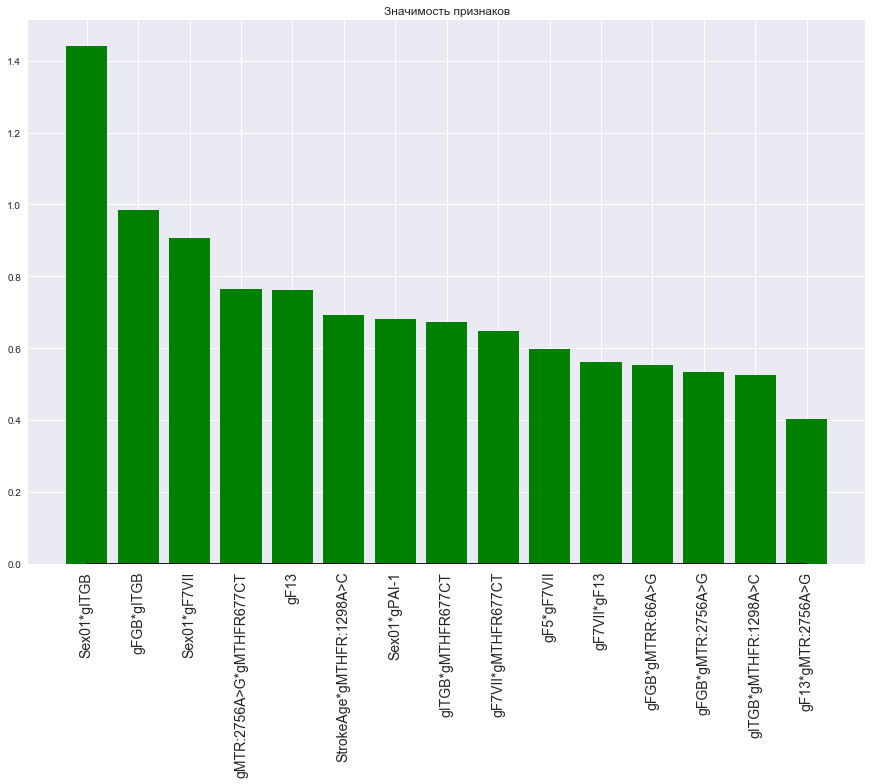

In [355]:
poly = PolynomialFeatures(interaction_only=True)
output_nparray = poly.fit_transform(X_train)
target_feature_names = ['*'.join(['{}'.format(pair[0]) for pair in tuple_ if pair[1]!=0]) for tuple_ in 
                        [zip(X.columns,p) for p in poly.powers_]]
importances = log_reg.coef_[0]
indices = np.argsort(np.abs(importances))[::-1]
FEATURE_COUNT = 15
target_feature_names_sorted = [target_feature_names[i] for i in indices[:FEATURE_COUNT]]
plt.figure(figsize=(15,10))
plt.title("Значимость признаков")
plt.bar(range(FEATURE_COUNT), np.abs(importances[indices[:FEATURE_COUNT]]),
       color="green", align="center")
plt.xticks(range(FEATURE_COUNT), target_feature_names_sorted, fontsize=14, rotation=90)
plt.hlines(0, 0, FEATURE_COUNT-1)

             precision    recall  f1-score   support

          0       0.89      0.92      0.90        60
          1       0.90      0.87      0.89        54

avg / total       0.90      0.89      0.89       114

F1 score:  0.88679245283
Roc_auc_score: 0.962037037037


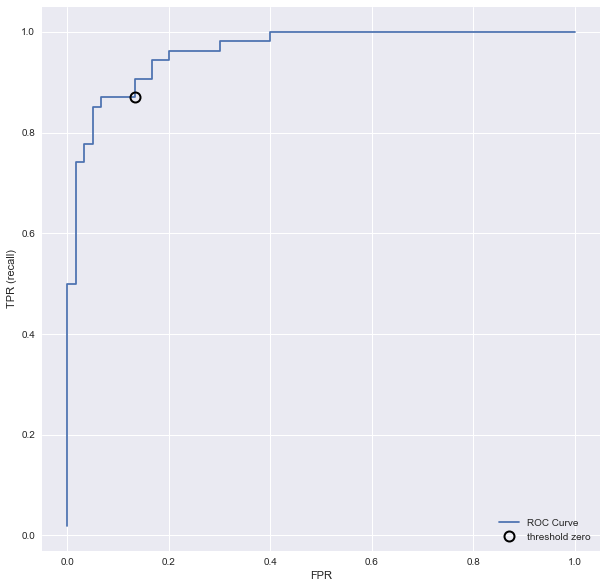

In [356]:
pred_x = X_train_prep
pred_y = y_train
pred_log_reg = log_reg.predict(pred_x)

confusion = confusion_matrix(pred_y, pred_log_reg)
print(classification_report(pred_y, pred_log_reg))
print("F1 score: ", f1_score(pred_y, pred_log_reg))
print("Roc_auc_score:", roc_auc_score(pred_y, log_reg.decision_function(pred_x)))
plt.figure(figsize=(10, 10))
fpr, tpr, thresholds = roc_curve(pred_y, log_reg.decision_function(pred_x))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

Score:  0.565217391304 Test score:  0.51724137931 Best params:  {'C': 1, 'penalty': 'l2'}


<module 'pylab' from '/home/user/Desktop/machine_learning/myvenv/lib/python3.6/site-packages/pylab.py'>

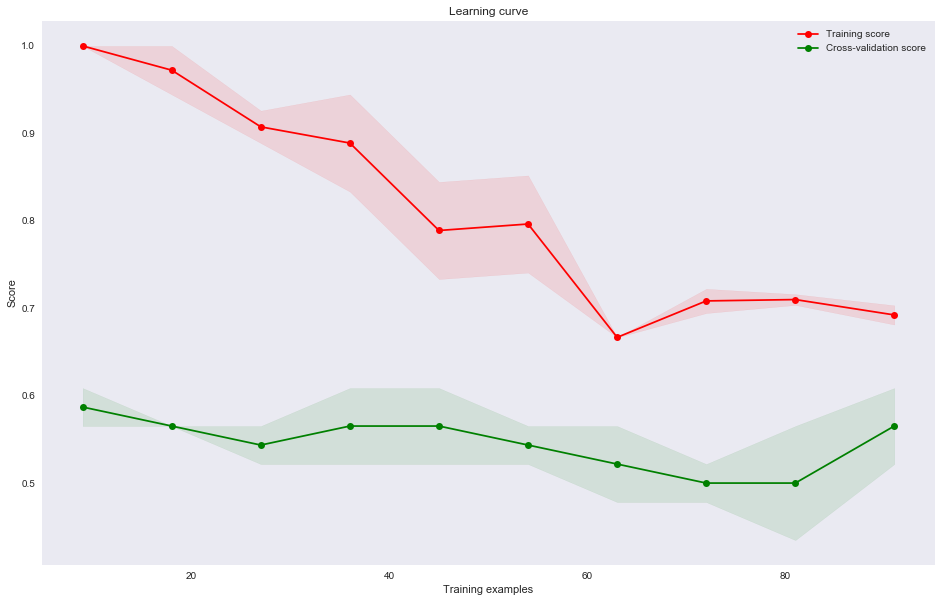

In [357]:
train_new_feature = pd.DataFrame(X_train_prep, columns=target_feature_names)
test_new_feature = pd.DataFrame(X_test_prep, columns=target_feature_names)
column_ = target_feature_names[16:]
#for i in X_train.keys():
#    if i not in column_:
 #       column_.append(i)
train_new_feature = train_new_feature.drop(column_, axis=1)
test_new_feature = test_new_feature.drop(column_, axis=1)
grid_search = GridSearchCV(LogisticRegression(), {"C": [0.001, 0.01, 0.1, 1, 3, 5, 10, 100, 500, 1000], "penalty": ["l2", "l1"]}, cv=cv)
grid_search.fit(train_new_feature, y_train)
log_reg_new = grid_search.best_estimator_
print("Score: ", grid_search.best_score_,"Test score: ", log_reg_new.score(test_new_feature, y_test), "Best params: ", grid_search.best_params_)
learning_curve_model(train_new_feature, y_train, log_reg_new, cv, np.linspace(0.1, 1.0, 10))

In [13]:
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[110, 110], feature_columns=feature_columns)
dnn_clf.fit(x=X_train, y=y_train.values, steps=5000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8059810b38>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by movin

/home/user/Desktop/machine_learning/myvenv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpyyhytdw9/model.ckpt.
INFO:tensorflow:loss = 0.712721, step = 1
INFO:tensorflow:global_step/sec: 177.346
INFO:tensorflow:loss = 0.512856, step = 101 (0.566 sec)
INFO:tensorflow:global_step/sec: 173.641
INFO:tensorflow:loss = 0.360765, step = 201 (0.582 sec)
INFO:tensorflow:global_step/sec: 178.245
INFO:tensorflow:loss = 0.216599, step = 301 (0.554 sec)
INFO:tensorflow:global_step/sec: 167.27
INFO:tensorflow:loss = 0.114627, step = 401 (0.598 sec)
INFO:tensorflow:global_step/sec: 174.758
INFO:tensorflow:loss = 0.0628538, step = 501 (0.574 sec)
INFO:tensorflow:global_st

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x7f8059954be0>, 'hidden_units': [110, 110], 'feature_columns': (_RealValuedColumn(column_name='', dimension=14, default_value=None, dtype=tf.float64, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x7f805f1c0d90>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [14]:
dnn_clf.evaluate(X_test, y_test.values)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/home/user/Desktop/machine_learning/myvenv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-05-14-15:22:56
INFO:tensorflow:Restoring parameters from /tmp/tmpyyhytdw9/model.ckpt-5000
INFO:tensorflow:Finished evaluation at 2017-05-14-15:22:56
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.551724, accuracy/baseline_label_mean = 0.482759, accuracy/threshold_0.500000_mean = 0.551724, auc = 0.592857, global_step = 5000, labels/actual_label_mean = 0.482759, labels/prediction_mean = 0.449857, loss = 3.03901, precision/positive_threshold_0.500000_mean = 0.538462, recall/positive_threshold_0.500000_mean = 0.5


{'accuracy': 0.55172414,
 'accuracy/baseline_label_mean': 0.48275861,
 'accuracy/threshold_0.500000_mean': 0.55172414,
 'auc': 0.59285712,
 'global_step': 5000,
 'labels/actual_label_mean': 0.48275861,
 'labels/prediction_mean': 0.44985712,
 'loss': 3.039012,
 'precision/positive_threshold_0.500000_mean': 0.53846157,
 'recall/positive_threshold_0.500000_mean': 0.5}

In [15]:
from keras.utils.np_utils import to_categorical
#y = to_categorical(y_train.values, num_classes=None)
model = Sequential()
model.add(Dense(110, input_dim=X_train_prep.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(110, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_prep, y_train.values.reshape(-1, 1), epochs=5000)

Epoch 1/5000
114/114 [==============================] - 0s - loss: 0.8167 - acc: 0.5088     
Epoch 2/5000
114/114 [==============================] - 0s - loss: 0.7351 - acc: 0.5965     
Epoch 3/5000
114/114 [==============================] - 0s - loss: 0.7031 - acc: 0.5965     
Epoch 4/5000
114/114 [==============================] - 0s - loss: 0.7388 - acc: 0.6053     
Epoch 5/5000
114/114 [==============================] - 0s - loss: 0.7270 - acc: 0.6228     
Epoch 6/5000
114/114 [==============================] - 0s - loss: 0.7188 - acc: 0.6228     
Epoch 7/5000
114/114 [==============================] - 0s - loss: 0.6981 - acc: 0.5526     
Epoch 8/5000
114/114 [==============================] - 0s - loss: 0.6934 - acc: 0.6316     
Epoch 9/5000
114/114 [==============================] - 0s - loss: 0.6071 - acc: 0.6754     
Epoch 10/5000
114/114 [==============================] - 0s - loss: 0.6776 - acc: 0.6491     
Epoch 11/5000
114/114 [==============================] - 0s - loss: 0

114/114 [==============================] - 0s - loss: 0.1532 - acc: 0.9474     
Epoch 89/5000
114/114 [==============================] - 0s - loss: 0.1524 - acc: 0.9561     
Epoch 90/5000
114/114 [==============================] - 0s - loss: 0.1144 - acc: 0.9825     
Epoch 91/5000
114/114 [==============================] - 0s - loss: 0.1557 - acc: 0.9298     
Epoch 92/5000
114/114 [==============================] - 0s - loss: 0.1247 - acc: 0.9561     
Epoch 93/5000
114/114 [==============================] - 0s - loss: 0.1308 - acc: 0.9649     
Epoch 94/5000
114/114 [==============================] - 0s - loss: 0.1202 - acc: 0.9825     
Epoch 95/5000
114/114 [==============================] - 0s - loss: 0.1677 - acc: 0.9211     
Epoch 96/5000
114/114 [==============================] - 0s - loss: 0.1108 - acc: 0.9737     
Epoch 97/5000
114/114 [==============================] - 0s - loss: 0.1192 - acc: 0.9561     
Epoch 98/5000
114/114 [==============================] - 0s - loss: 0.1256

114/114 [==============================] - 0s - loss: 0.0272 - acc: 1.0000     
Epoch 173/5000
114/114 [==============================] - 0s - loss: 0.0310 - acc: 0.9912     
Epoch 174/5000
114/114 [==============================] - 0s - loss: 0.0559 - acc: 0.9737     
Epoch 175/5000
114/114 [==============================] - 0s - loss: 0.0508 - acc: 0.9912     
Epoch 176/5000
114/114 [==============================] - 0s - loss: 0.0309 - acc: 0.9912     
Epoch 177/5000
114/114 [==============================] - 0s - loss: 0.0237 - acc: 1.0000     
Epoch 178/5000
114/114 [==============================] - 0s - loss: 0.0529 - acc: 0.9825     
Epoch 179/5000
114/114 [==============================] - 0s - loss: 0.0323 - acc: 0.9912     
Epoch 180/5000
114/114 [==============================] - 0s - loss: 0.0778 - acc: 0.9825     
Epoch 181/5000
114/114 [==============================] - 0s - loss: 0.0260 - acc: 1.0000     
Epoch 182/5000
114/114 [==============================] - 0s - lo

114/114 [==============================] - 0s - loss: 0.0097 - acc: 1.0000     
Epoch 259/5000
114/114 [==============================] - ETA: 0s - loss: 0.0028 - acc: 1.000 - 0s - loss: 0.0263 - acc: 0.9912     
Epoch 260/5000
114/114 [==============================] - 0s - loss: 0.0119 - acc: 1.0000     
Epoch 261/5000
114/114 [==============================] - 0s - loss: 0.0212 - acc: 0.9825     
Epoch 262/5000
114/114 [==============================] - 0s - loss: 0.0151 - acc: 1.0000     
Epoch 263/5000
114/114 [==============================] - 0s - loss: 0.0227 - acc: 0.9912     
Epoch 264/5000
114/114 [==============================] - 0s - loss: 0.0085 - acc: 1.0000     
Epoch 265/5000
114/114 [==============================] - 0s - loss: 0.0450 - acc: 0.9825     
Epoch 266/5000
114/114 [==============================] - 0s - loss: 0.0200 - acc: 0.9912     
Epoch 267/5000
114/114 [==============================] - 0s - loss: 0.0095 - acc: 1.0000     
Epoch 268/5000
114/114 [===

114/114 [==============================] - 0s - loss: 0.0172 - acc: 0.9912     
Epoch 343/5000
114/114 [==============================] - 0s - loss: 0.0107 - acc: 1.0000     
Epoch 344/5000
114/114 [==============================] - ETA: 0s - loss: 0.0011 - acc: 1.000 - 0s - loss: 0.0029 - acc: 1.0000     
Epoch 345/5000
114/114 [==============================] - 0s - loss: 0.0059 - acc: 1.0000     
Epoch 346/5000
114/114 [==============================] - 0s - loss: 0.0061 - acc: 1.0000     
Epoch 347/5000
114/114 [==============================] - 0s - loss: 0.0032 - acc: 1.0000     
Epoch 348/5000
114/114 [==============================] - 0s - loss: 0.0208 - acc: 0.9912     
Epoch 349/5000
114/114 [==============================] - 0s - loss: 0.0144 - acc: 1.0000     
Epoch 350/5000
114/114 [==============================] - 0s - loss: 0.0079 - acc: 1.0000     
Epoch 351/5000
114/114 [==============================] - 0s - loss: 0.0052 - acc: 1.0000     
Epoch 352/5000
114/114 [===

114/114 [==============================] - 0s - loss: 0.0029 - acc: 1.0000     
Epoch 427/5000
114/114 [==============================] - 0s - loss: 0.0309 - acc: 0.9912     
Epoch 428/5000
114/114 [==============================] - 0s - loss: 0.0034 - acc: 1.0000     
Epoch 429/5000
114/114 [==============================] - 0s - loss: 0.0146 - acc: 1.0000     
Epoch 430/5000
114/114 [==============================] - 0s - loss: 0.0021 - acc: 1.0000         
Epoch 431/5000
114/114 [==============================] - 0s - loss: 0.0174 - acc: 0.9912     
Epoch 432/5000
114/114 [==============================] - 0s - loss: 0.0064 - acc: 1.0000     
Epoch 433/5000
114/114 [==============================] - 0s - loss: 0.0085 - acc: 1.0000     
Epoch 434/5000
114/114 [==============================] - 0s - loss: 0.0097 - acc: 0.9912     
Epoch 435/5000
114/114 [==============================] - 0s - loss: 0.0026 - acc: 1.0000     
Epoch 436/5000
114/114 [==============================] - 0s 

114/114 [==============================] - 0s - loss: 0.0106 - acc: 0.9912     
Epoch 511/5000
114/114 [==============================] - ETA: 0s - loss: 5.0308e-04 - acc: 1.000 - 0s - loss: 0.0017 - acc: 1.0000         
Epoch 512/5000
114/114 [==============================] - 0s - loss: 0.0040 - acc: 1.0000     
Epoch 513/5000
114/114 [==============================] - 0s - loss: 0.0030 - acc: 1.0000     
Epoch 514/5000
114/114 [==============================] - 0s - loss: 0.0063 - acc: 1.0000     
Epoch 515/5000
114/114 [==============================] - 0s - loss: 0.0065 - acc: 1.0000     
Epoch 516/5000
114/114 [==============================] - 0s - loss: 0.0185 - acc: 0.9912     
Epoch 517/5000
114/114 [==============================] - 0s - loss: 0.0010 - acc: 1.0000         
Epoch 518/5000
114/114 [==============================] - 0s - loss: 0.0090 - acc: 0.9912     
Epoch 519/5000
114/114 [==============================] - 0s - loss: 0.0039 - acc: 1.0000     
Epoch 520/5000


114/114 [==============================] - 0s - loss: 0.0141 - acc: 0.9912         
Epoch 594/5000
114/114 [==============================] - 0s - loss: 0.0022 - acc: 1.0000     
Epoch 595/5000
114/114 [==============================] - 0s - loss: 0.0177 - acc: 0.9912         
Epoch 596/5000
114/114 [==============================] - 0s - loss: 0.0022 - acc: 1.0000     
Epoch 597/5000
114/114 [==============================] - 0s - loss: 0.0021 - acc: 1.0000         
Epoch 598/5000
114/114 [==============================] - 0s - loss: 0.0035 - acc: 1.0000     
Epoch 599/5000
114/114 [==============================] - 0s - loss: 0.0018 - acc: 1.0000     
Epoch 600/5000
114/114 [==============================] - 0s - loss: 0.0059 - acc: 1.0000     
Epoch 601/5000
114/114 [==============================] - 0s - loss: 0.0022 - acc: 1.0000         
Epoch 602/5000
114/114 [==============================] - 0s - loss: 0.0019 - acc: 1.0000     
Epoch 603/5000
114/114 [=========================

114/114 [==============================] - 0s - loss: 4.9780e-04 - acc: 1.0000     
Epoch 678/5000
114/114 [==============================] - 0s - loss: 0.0038 - acc: 1.0000     
Epoch 679/5000
114/114 [==============================] - 0s - loss: 0.0164 - acc: 0.9912     
Epoch 680/5000
114/114 [==============================] - 0s - loss: 0.0083 - acc: 0.9912         
Epoch 681/5000
114/114 [==============================] - 0s - loss: 0.0010 - acc: 1.0000         
Epoch 682/5000
114/114 [==============================] - 0s - loss: 0.0027 - acc: 1.0000     
Epoch 683/5000
114/114 [==============================] - 0s - loss: 5.6926e-04 - acc: 1.0000 
Epoch 684/5000
114/114 [==============================] - 0s - loss: 0.0023 - acc: 1.0000     
Epoch 685/5000
114/114 [==============================] - 0s - loss: 0.0027 - acc: 1.0000     
Epoch 686/5000
114/114 [==============================] - 0s - loss: 0.0030 - acc: 1.0000     
Epoch 687/5000
114/114 [=============================

114/114 [==============================] - 0s - loss: 0.0090 - acc: 1.0000     
Epoch 762/5000
114/114 [==============================] - 0s - loss: 0.0105 - acc: 0.9912         
Epoch 763/5000
114/114 [==============================] - 0s - loss: 0.0590 - acc: 0.9912     
Epoch 764/5000
114/114 [==============================] - 0s - loss: 0.0037 - acc: 1.0000     
Epoch 765/5000
114/114 [==============================] - 0s - loss: 8.8831e-04 - acc: 1.0000 
Epoch 766/5000
114/114 [==============================] - 0s - loss: 0.0014 - acc: 1.0000     
Epoch 767/5000
114/114 [==============================] - 0s - loss: 0.0070 - acc: 0.9912     
Epoch 768/5000
114/114 [==============================] - 0s - loss: 0.0036 - acc: 1.0000     
Epoch 769/5000
114/114 [==============================] - 0s - loss: 0.0022 - acc: 1.0000     
Epoch 770/5000
114/114 [==============================] - 0s - loss: 0.0092 - acc: 0.9912     
Epoch 771/5000
114/114 [==============================] - 0s 

114/114 [==============================] - 0s - loss: 0.0045 - acc: 1.0000     
Epoch 846/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 847/5000
114/114 [==============================] - 0s - loss: 9.5064e-04 - acc: 1.0000     
Epoch 848/5000
114/114 [==============================] - 0s - loss: 0.0034 - acc: 1.0000     
Epoch 849/5000
114/114 [==============================] - 0s - loss: 8.3232e-04 - acc: 1.0000     
Epoch 850/5000
114/114 [==============================] - 0s - loss: 0.0323 - acc: 0.9912     
Epoch 851/5000
114/114 [==============================] - 0s - loss: 4.5750e-04 - acc: 1.0000     
Epoch 852/5000
114/114 [==============================] - 0s - loss: 0.0015 - acc: 1.0000     
Epoch 853/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000         
Epoch 854/5000
114/114 [==============================] - 0s - loss: 0.0215 - acc: 0.9912         
Epoch 855/5000
114/114 [=====================

114/114 [==============================] - 0s - loss: 0.0013 - acc: 1.0000         
Epoch 930/5000
114/114 [==============================] - 0s - loss: 8.6525e-04 - acc: 1.0000     
Epoch 931/5000
114/114 [==============================] - 0s - loss: 2.6484e-04 - acc: 1.0000     
Epoch 932/5000
114/114 [==============================] - 0s - loss: 2.9765e-04 - acc: 1.0000     
Epoch 933/5000
114/114 [==============================] - 0s - loss: 5.2955e-04 - acc: 1.0000     
Epoch 934/5000
114/114 [==============================] - 0s - loss: 3.2466e-04 - acc: 1.0000     
Epoch 935/5000
114/114 [==============================] - 0s - loss: 0.0014 - acc: 1.0000     
Epoch 936/5000
114/114 [==============================] - 0s - loss: 4.9538e-04 - acc: 1.0000     
Epoch 937/5000
114/114 [==============================] - 0s - loss: 2.4704e-04 - acc: 1.0000     
Epoch 938/5000
114/114 [==============================] - 0s - loss: 4.1549e-04 - acc: 1.0000     
Epoch 939/5000
114/114 [=====

114/114 [==============================] - 0s - loss: 4.8027e-04 - acc: 1.0000     
Epoch 1013/5000
114/114 [==============================] - 0s - loss: 0.0211 - acc: 0.9912     
Epoch 1014/5000
114/114 [==============================] - 0s - loss: 1.3055e-04 - acc: 1.0000     
Epoch 1015/5000
114/114 [==============================] - 0s - loss: 2.2414e-04 - acc: 1.0000     
Epoch 1016/5000
114/114 [==============================] - 0s - loss: 2.5201e-04 - acc: 1.0000     
Epoch 1017/5000
114/114 [==============================] - 0s - loss: 1.8498e-04 - acc: 1.0000     
Epoch 1018/5000
114/114 [==============================] - 0s - loss: 0.0186 - acc: 0.9912         
Epoch 1019/5000
114/114 [==============================] - 0s - loss: 1.8438e-04 - acc: 1.0000     
Epoch 1020/5000
114/114 [==============================] - 0s - loss: 0.0022 - acc: 1.0000         
Epoch 1021/5000
114/114 [==============================] - 0s - loss: 0.0024 - acc: 1.0000     
Epoch 1022/5000
114/114 

114/114 [==============================] - 0s - loss: 7.0993e-04 - acc: 1.0000 
Epoch 1095/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000     
Epoch 1096/5000
114/114 [==============================] - 0s - loss: 5.1604e-04 - acc: 1.0000     
Epoch 1097/5000
114/114 [==============================] - 0s - loss: 7.6216e-04 - acc: 1.0000     
Epoch 1098/5000
114/114 [==============================] - 0s - loss: 0.0024 - acc: 1.0000     
Epoch 1099/5000
114/114 [==============================] - 0s - loss: 0.0082 - acc: 0.9912     
Epoch 1100/5000
114/114 [==============================] - 0s - loss: 0.0018 - acc: 1.0000         
Epoch 1101/5000
114/114 [==============================] - 0s - loss: 0.0038 - acc: 1.0000     
Epoch 1102/5000
114/114 [==============================] - 0s - loss: 0.0034 - acc: 1.0000     
Epoch 1103/5000
114/114 [==============================] - 0s - loss: 0.0298 - acc: 0.9912         
Epoch 1104/5000
114/114 [===============

114/114 [==============================] - 0s - loss: 4.7588e-04 - acc: 1.0000     
Epoch 1178/5000
114/114 [==============================] - 0s - loss: 0.0010 - acc: 1.0000         
Epoch 1179/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000         
Epoch 1180/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000         
Epoch 1181/5000
114/114 [==============================] - 0s - loss: 0.0044 - acc: 1.0000         
Epoch 1182/5000
114/114 [==============================] - 0s - loss: 4.0006e-04 - acc: 1.0000     
Epoch 1183/5000
114/114 [==============================] - 0s - loss: 0.0139 - acc: 0.9912     
Epoch 1184/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000         
Epoch 1185/5000
114/114 [==============================] - 0s - loss: 2.3639e-04 - acc: 1.0000     
Epoch 1186/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 1187/5000
114/114 

114/114 [==============================] - ETA: 0s - loss: 0.0011 - acc: 1.000 - 0s - loss: 9.0181e-04 - acc: 1.0000 
Epoch 1259/5000
114/114 [==============================] - 0s - loss: 5.6433e-04 - acc: 1.0000 
Epoch 1260/5000
114/114 [==============================] - 0s - loss: 1.8551e-04 - acc: 1.0000     
Epoch 1261/5000
114/114 [==============================] - 0s - loss: 0.0154 - acc: 0.9912         
Epoch 1262/5000
114/114 [==============================] - 0s - loss: 6.3100e-04 - acc: 1.0000     
Epoch 1263/5000
114/114 [==============================] - ETA: 0s - loss: 2.5934e-04 - acc: 1.000 - 0s - loss: 3.2379e-04 - acc: 1.0000     
Epoch 1264/5000
114/114 [==============================] - 0s - loss: 7.6310e-04 - acc: 1.0000     
Epoch 1265/5000
114/114 [==============================] - ETA: 0s - loss: 0.0012 - acc: 1.000 - 0s - loss: 0.0010 - acc: 1.0000     
Epoch 1266/5000
114/114 [==============================] - 0s - loss: 2.7598e-04 - acc: 1.0000     
Epoch 1267

114/114 [==============================] - 0s - loss: 0.0013 - acc: 1.0000     
Epoch 1339/5000
114/114 [==============================] - 0s - loss: 0.0030 - acc: 1.0000         
Epoch 1340/5000
114/114 [==============================] - 0s - loss: 0.0091 - acc: 0.9912     
Epoch 1341/5000
114/114 [==============================] - 0s - loss: 0.0034 - acc: 1.0000     
Epoch 1342/5000
114/114 [==============================] - 0s - loss: 0.0107 - acc: 0.9912         
Epoch 1343/5000
114/114 [==============================] - 0s - loss: 0.0613 - acc: 0.9912     
Epoch 1344/5000
114/114 [==============================] - 0s - loss: 0.0018 - acc: 1.0000         
Epoch 1345/5000
114/114 [==============================] - 0s - loss: 0.0014 - acc: 1.0000         
Epoch 1346/5000
114/114 [==============================] - 0s - loss: 1.9541e-04 - acc: 1.0000     
Epoch 1347/5000
114/114 [==============================] - 0s - loss: 8.9368e-04 - acc: 1.0000 
Epoch 1348/5000
114/114 [===========

114/114 [==============================] - 0s - loss: 3.5685e-04 - acc: 1.0000     
Epoch 1421/5000
114/114 [==============================] - 0s - loss: 5.6712e-04 - acc: 1.0000     
Epoch 1422/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000     
Epoch 1423/5000
114/114 [==============================] - 0s - loss: 8.4004e-04 - acc: 1.0000     
Epoch 1424/5000
114/114 [==============================] - 0s - loss: 6.3468e-04 - acc: 1.0000     
Epoch 1425/5000
114/114 [==============================] - 0s - loss: 7.6959e-04 - acc: 1.0000     
Epoch 1426/5000
114/114 [==============================] - 0s - loss: 7.8667e-04 - acc: 1.0000     
Epoch 1427/5000
114/114 [==============================] - 0s - loss: 8.9826e-04 - acc: 1.0000 
Epoch 1428/5000
114/114 [==============================] - 0s - loss: 7.8953e-04 - acc: 1.0000     
Epoch 1429/5000
114/114 [==============================] - 0s - loss: 0.0075 - acc: 1.0000     
Epoch 1430/5000
114/114 [===

114/114 [==============================] - 0s - loss: 5.7168e-04 - acc: 1.0000     
Epoch 1504/5000
114/114 [==============================] - 0s - loss: 4.9677e-04 - acc: 1.0000     
Epoch 1505/5000
114/114 [==============================] - 0s - loss: 0.0261 - acc: 0.9912     
Epoch 1506/5000
114/114 [==============================] - 0s - loss: 5.0153e-04 - acc: 1.0000     
Epoch 1507/5000
114/114 [==============================] - 0s - loss: 6.7096e-04 - acc: 1.0000     
Epoch 1508/5000
114/114 [==============================] - 0s - loss: 6.7770e-04 - acc: 1.0000 
Epoch 1509/5000
114/114 [==============================] - 0s - loss: 0.0057 - acc: 1.0000     
Epoch 1510/5000
114/114 [==============================] - 0s - loss: 2.7500e-04 - acc: 1.0000     
Epoch 1511/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000     
Epoch 1512/5000
114/114 [==============================] - 0s - loss: 0.0010 - acc: 1.0000         
Epoch 1513/5000
114/114 [=======

114/114 [==============================] - 0s - loss: 5.1004e-04 - acc: 1.0000     
Epoch 1586/5000
114/114 [==============================] - 0s - loss: 1.2970e-04 - acc: 1.0000     
Epoch 1587/5000
114/114 [==============================] - 0s - loss: 0.0026 - acc: 1.0000         
Epoch 1588/5000
114/114 [==============================] - 0s - loss: 0.0023 - acc: 1.0000         
Epoch 1589/5000
114/114 [==============================] - 0s - loss: 2.7619e-04 - acc: 1.0000     
Epoch 1590/5000
114/114 [==============================] - 0s - loss: 2.2079e-04 - acc: 1.0000     
Epoch 1591/5000
114/114 [==============================] - 0s - loss: 1.5558e-04 - acc: 1.0000     
Epoch 1592/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 1593/5000
114/114 [==============================] - 0s - loss: 0.0063 - acc: 1.0000         
Epoch 1594/5000
114/114 [==============================] - 0s - loss: 5.8637e-04 - acc: 1.0000     
Epoch 1595/5000
114/

114/114 [==============================] - 0s - loss: 0.0051 - acc: 1.0000         
Epoch 1667/5000
114/114 [==============================] - 0s - loss: 3.9480e-04 - acc: 1.0000     
Epoch 1668/5000
114/114 [==============================] - 0s - loss: 5.1033e-04 - acc: 1.0000 
Epoch 1669/5000
114/114 [==============================] - 0s - loss: 8.6569e-05 - acc: 1.0000     
Epoch 1670/5000
114/114 [==============================] - 0s - loss: 0.0051 - acc: 1.0000         
Epoch 1671/5000
114/114 [==============================] - 0s - loss: 1.1702e-04 - acc: 1.0000     
Epoch 1672/5000
114/114 [==============================] - 0s - loss: 3.4438e-04 - acc: 1.0000     
Epoch 1673/5000
114/114 [==============================] - 0s - loss: 4.8720e-05 - acc: 1.0000     
Epoch 1674/5000
114/114 [==============================] - 0s - loss: 2.1050e-04 - acc: 1.0000     
Epoch 1675/5000
114/114 [==============================] - 0s - loss: 5.1909e-04 - acc: 1.0000     
Epoch 1676/5000
114/

114/114 [==============================] - 0s - loss: 5.3512e-04 - acc: 1.0000     
Epoch 1749/5000
114/114 [==============================] - 0s - loss: 1.0252e-04 - acc: 1.0000     
Epoch 1750/5000
114/114 [==============================] - 0s - loss: 1.1837e-04 - acc: 1.0000     
Epoch 1751/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 1752/5000
114/114 [==============================] - 0s - loss: 2.0588e-04 - acc: 1.0000     
Epoch 1753/5000
114/114 [==============================] - 0s - loss: 2.0849e-04 - acc: 1.0000     
Epoch 1754/5000
114/114 [==============================] - 0s - loss: 6.1878e-05 - acc: 1.0000     
Epoch 1755/5000
114/114 [==============================] - 0s - loss: 0.0013 - acc: 1.0000         
Epoch 1756/5000
114/114 [==============================] - 0s - loss: 9.8721e-05 - acc: 1.0000     
Epoch 1757/5000
114/114 [==============================] - 0s - loss: 0.0047 - acc: 1.0000         
Epoch 1758/5000
114/

114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000         
Epoch 1829/5000
114/114 [==============================] - 0s - loss: 1.6687e-04 - acc: 1.0000     
Epoch 1830/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 1831/5000
114/114 [==============================] - 0s - loss: 1.0509e-04 - acc: 1.0000     
Epoch 1832/5000
114/114 [==============================] - ETA: 0s - loss: 4.5189e-05 - acc: 1.000 - 0s - loss: 1.1209e-04 - acc: 1.0000     
Epoch 1833/5000
114/114 [==============================] - 0s - loss: 8.8495e-04 - acc: 1.0000 
Epoch 1834/5000
114/114 [==============================] - 0s - loss: 7.6948e-05 - acc: 1.0000     
Epoch 1835/5000
114/114 [==============================] - 0s - loss: 0.0013 - acc: 1.0000         
Epoch 1836/5000
114/114 [==============================] - 0s - loss: 6.5810e-05 - acc: 1.0000     
Epoch 1837/5000
114/114 [==============================] - 0s - loss: 1.6015e-04 -

114/114 [==============================] - 0s - loss: 0.0013 - acc: 1.0000     
Epoch 1911/5000
114/114 [==============================] - 0s - loss: 5.5825e-04 - acc: 1.0000     
Epoch 1912/5000
114/114 [==============================] - 0s - loss: 6.3112e-04 - acc: 1.0000 
Epoch 1913/5000
114/114 [==============================] - 0s - loss: 0.0132 - acc: 0.9912         
Epoch 1914/5000
114/114 [==============================] - 0s - loss: 0.0957 - acc: 0.9912         
Epoch 1915/5000
114/114 [==============================] - 0s - loss: 3.6556e-04 - acc: 1.0000     
Epoch 1916/5000
114/114 [==============================] - 0s - loss: 5.0791e-04 - acc: 1.0000     
Epoch 1917/5000
114/114 [==============================] - 0s - loss: 0.0013 - acc: 1.0000         
Epoch 1918/5000
114/114 [==============================] - 0s - loss: 8.7335e-04 - acc: 1.0000     
Epoch 1919/5000
114/114 [==============================] - 0s - loss: 2.5182e-04 - acc: 1.0000     
Epoch 1920/5000
114/114 

114/114 [==============================] - 0s - loss: 0.0024 - acc: 1.0000         
Epoch 1993/5000
114/114 [==============================] - 0s - loss: 0.0333 - acc: 0.9912         
Epoch 1994/5000
114/114 [==============================] - 0s - loss: 0.0020 - acc: 1.0000         
Epoch 1995/5000
114/114 [==============================] - 0s - loss: 9.5442e-05 - acc: 1.0000     
Epoch 1996/5000
114/114 [==============================] - 0s - loss: 4.7780e-04 - acc: 1.0000     
Epoch 1997/5000
114/114 [==============================] - 0s - loss: 4.9055e-04 - acc: 1.0000     
Epoch 1998/5000
114/114 [==============================] - 0s - loss: 0.0321 - acc: 0.9912     
Epoch 1999/5000
114/114 [==============================] - 0s - loss: 3.4647e-04 - acc: 1.0000     
Epoch 2000/5000
114/114 [==============================] - 0s - loss: 0.0057 - acc: 1.0000         
Epoch 2001/5000
114/114 [==============================] - 0s - loss: 0.0329 - acc: 0.9912         
Epoch 2002/5000
114/

114/114 [==============================] - 0s - loss: 1.7256e-04 - acc: 1.0000     
Epoch 2074/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000         
Epoch 2075/5000
114/114 [==============================] - 0s - loss: 2.4634e-04 - acc: 1.0000     
Epoch 2076/5000
114/114 [==============================] - 0s - loss: 4.7688e-04 - acc: 1.0000 
Epoch 2077/5000
114/114 [==============================] - 0s - loss: 4.6577e-04 - acc: 1.0000 
Epoch 2078/5000
114/114 [==============================] - 0s - loss: 2.2410e-04 - acc: 1.0000     
Epoch 2079/5000
114/114 [==============================] - 0s - loss: 3.9551e-04 - acc: 1.0000     
Epoch 2080/5000
114/114 [==============================] - 0s - loss: 9.7416e-05 - acc: 1.0000     
Epoch 2081/5000
114/114 [==============================] - 0s - loss: 3.5415e-04 - acc: 1.0000     
Epoch 2082/5000
114/114 [==============================] - 0s - loss: 2.6133e-04 - acc: 1.0000     
Epoch 2083/5000
114/114 

114/114 [==============================] - 0s - loss: 1.0456e-04 - acc: 1.0000     
Epoch 2156/5000
114/114 [==============================] - 0s - loss: 0.0044 - acc: 1.0000     
Epoch 2157/5000
114/114 [==============================] - 0s - loss: 1.3623e-04 - acc: 1.0000     
Epoch 2158/5000
114/114 [==============================] - 0s - loss: 3.8158e-04 - acc: 1.0000     
Epoch 2159/5000
114/114 [==============================] - 0s - loss: 1.1094e-04 - acc: 1.0000     
Epoch 2160/5000
114/114 [==============================] - 0s - loss: 1.1242e-04 - acc: 1.0000     
Epoch 2161/5000
114/114 [==============================] - 0s - loss: 2.0871e-04 - acc: 1.0000     
Epoch 2162/5000
114/114 [==============================] - 0s - loss: 1.9800e-04 - acc: 1.0000     
Epoch 2163/5000
114/114 [==============================] - 0s - loss: 0.0128 - acc: 0.9912         
Epoch 2164/5000
114/114 [==============================] - 0s - loss: 6.7474e-04 - acc: 1.0000     
Epoch 2165/5000
114/

114/114 [==============================] - 0s - loss: 4.9702e-04 - acc: 1.0000     
Epoch 2238/5000
114/114 [==============================] - 0s - loss: 2.1776e-04 - acc: 1.0000     
Epoch 2239/5000
114/114 [==============================] - 0s - loss: 1.1829e-05 - acc: 1.0000     
Epoch 2240/5000
114/114 [==============================] - 0s - loss: 4.5158e-05 - acc: 1.0000     
Epoch 2241/5000
114/114 [==============================] - 0s - loss: 1.1589e-05 - acc: 1.0000     
Epoch 2242/5000
114/114 [==============================] - 0s - loss: 1.8771e-04 - acc: 1.0000     
Epoch 2243/5000
114/114 [==============================] - 0s - loss: 0.0048 - acc: 1.0000         
Epoch 2244/5000
114/114 [==============================] - 0s - loss: 0.0040 - acc: 1.0000         
Epoch 2245/5000
114/114 [==============================] - 0s - loss: 0.0057 - acc: 1.0000         
Epoch 2246/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000         
Epoch 2247/5000


114/114 [==============================] - 0s - loss: 0.0240 - acc: 0.9912         
Epoch 2319/5000
114/114 [==============================] - 0s - loss: 2.0918e-04 - acc: 1.0000     
Epoch 2320/5000
114/114 [==============================] - 0s - loss: 0.0017 - acc: 1.0000     
Epoch 2321/5000
114/114 [==============================] - 0s - loss: 1.0125e-04 - acc: 1.0000     
Epoch 2322/5000
114/114 [==============================] - 0s - loss: 6.3720e-05 - acc: 1.0000     
Epoch 2323/5000
114/114 [==============================] - 0s - loss: 4.7477e-04 - acc: 1.0000     
Epoch 2324/5000
114/114 [==============================] - 0s - loss: 0.0017 - acc: 1.0000     
Epoch 2325/5000
114/114 [==============================] - 0s - loss: 0.0026 - acc: 1.0000         
Epoch 2326/5000
114/114 [==============================] - 0s - loss: 3.4138e-04 - acc: 1.0000     
Epoch 2327/5000
114/114 [==============================] - 0s - loss: 3.7587e-04 - acc: 1.0000     
Epoch 2328/5000
114/114 

114/114 [==============================] - 0s - loss: 4.1446e-04 - acc: 1.0000     
Epoch 2401/5000
114/114 [==============================] - 0s - loss: 0.0017 - acc: 1.0000         
Epoch 2402/5000
114/114 [==============================] - 0s - loss: 2.8439e-04 - acc: 1.0000     
Epoch 2403/5000
114/114 [==============================] - 0s - loss: 1.5513e-04 - acc: 1.0000     
Epoch 2404/5000
114/114 [==============================] - 0s - loss: 1.0657e-04 - acc: 1.0000     
Epoch 2405/5000
114/114 [==============================] - 0s - loss: 6.7880e-04 - acc: 1.0000     
Epoch 2406/5000
114/114 [==============================] - 0s - loss: 8.4802e-04 - acc: 1.0000     
Epoch 2407/5000
114/114 [==============================] - 0s - loss: 0.0021 - acc: 1.0000     
Epoch 2408/5000
114/114 [==============================] - 0s - loss: 7.5318e-04 - acc: 1.0000     
Epoch 2409/5000
114/114 [==============================] - 0s - loss: 6.7921e-04 - acc: 1.0000     
Epoch 2410/5000
114/

114/114 [==============================] - 0s - loss: 7.4185e-04 - acc: 1.0000 
Epoch 2482/5000
114/114 [==============================] - 0s - loss: 2.7810e-04 - acc: 1.0000     
Epoch 2483/5000
114/114 [==============================] - 0s - loss: 6.6050e-05 - acc: 1.0000     
Epoch 2484/5000
114/114 [==============================] - 0s - loss: 4.5314e-05 - acc: 1.0000     
Epoch 2485/5000
114/114 [==============================] - 0s - loss: 2.4231e-04 - acc: 1.0000     
Epoch 2486/5000
114/114 [==============================] - 0s - loss: 3.4303e-04 - acc: 1.0000     
Epoch 2487/5000
114/114 [==============================] - 0s - loss: 4.2026e-04 - acc: 1.0000     
Epoch 2488/5000
114/114 [==============================] - 0s - loss: 4.9236e-05 - acc: 1.0000     
Epoch 2489/5000
114/114 [==============================] - 0s - loss: 8.4685e-04 - acc: 1.0000 
Epoch 2490/5000
114/114 [==============================] - 0s - loss: 1.4221e-04 - acc: 1.0000     
Epoch 2491/5000
114/114 

114/114 [==============================] - 0s - loss: 0.0119 - acc: 0.9912         
Epoch 2562/5000
114/114 [==============================] - 0s - loss: 2.4234e-04 - acc: 1.0000     
Epoch 2563/5000
114/114 [==============================] - 0s - loss: 4.4409e-04 - acc: 1.0000 
Epoch 2564/5000
114/114 [==============================] - 0s - loss: 4.0487e-05 - acc: 1.0000     
Epoch 2565/5000
114/114 [==============================] - ETA: 0s - loss: 4.4960e-04 - acc: 1.000 - 0s - loss: 2.6168e-04 - acc: 1.0000     
Epoch 2566/5000
114/114 [==============================] - ETA: 0s - loss: 8.7746e-05 - acc: 1.000 - 0s - loss: 6.1646e-05 - acc: 1.0000     
Epoch 2567/5000
114/114 [==============================] - 0s - loss: 1.4300e-04 - acc: 1.0000     
Epoch 2568/5000
114/114 [==============================] - 0s - loss: 0.0023 - acc: 1.0000         
Epoch 2569/5000
114/114 [==============================] - 0s - loss: 1.7019e-04 - acc: 1.0000     
Epoch 2570/5000
114/114 [===========

114/114 [==============================] - 0s - loss: 1.6109e-04 - acc: 1.0000     
Epoch 2642/5000
114/114 [==============================] - 0s - loss: 0.0027 - acc: 1.0000     
Epoch 2643/5000
114/114 [==============================] - 0s - loss: 2.2813e-04 - acc: 1.0000     
Epoch 2644/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000     
Epoch 2645/5000
114/114 [==============================] - 0s - loss: 1.9789e-04 - acc: 1.0000     
Epoch 2646/5000
114/114 [==============================] - 0s - loss: 6.0094e-05 - acc: 1.0000     
Epoch 2647/5000
114/114 [==============================] - ETA: 0s - loss: 5.6494e-05 - acc: 1.000 - 0s - loss: 6.9943e-05 - acc: 1.0000     
Epoch 2648/5000
114/114 [==============================] - 0s - loss: 0.0093 - acc: 1.0000     
Epoch 2649/5000
114/114 [==============================] - 0s - loss: 4.2871e-05 - acc: 1.0000     
Epoch 2650/5000
114/114 [==============================] - 0s - loss: 3.5489e-04 - acc

114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000     
Epoch 2724/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000         
Epoch 2725/5000
114/114 [==============================] - 0s - loss: 5.9236e-04 - acc: 1.0000 
Epoch 2726/5000
114/114 [==============================] - 0s - loss: 1.9339e-04 - acc: 1.0000     
Epoch 2727/5000
114/114 [==============================] - 0s - loss: 9.4262e-04 - acc: 1.0000     
Epoch 2728/5000
114/114 [==============================] - 0s - loss: 0.1095 - acc: 0.9912         
Epoch 2729/5000
114/114 [==============================] - 0s - loss: 2.9210e-04 - acc: 1.0000     
Epoch 2730/5000
114/114 [==============================] - 0s - loss: 3.7498e-04 - acc: 1.0000     
Epoch 2731/5000
114/114 [==============================] - 0s - loss: 3.8539e-05 - acc: 1.0000     
Epoch 2732/5000
114/114 [==============================] - 0s - loss: 0.0027 - acc: 1.0000         
Epoch 2733/5000
114/114 

114/114 [==============================] - 0s - loss: 2.4942e-04 - acc: 1.0000     
Epoch 2806/5000
114/114 [==============================] - 0s - loss: 1.3700e-04 - acc: 1.0000     
Epoch 2807/5000
114/114 [==============================] - 0s - loss: 1.2885e-04 - acc: 1.0000     
Epoch 2808/5000
114/114 [==============================] - 0s - loss: 7.9283e-05 - acc: 1.0000     
Epoch 2809/5000
114/114 [==============================] - 0s - loss: 1.5820e-04 - acc: 1.0000     
Epoch 2810/5000
114/114 [==============================] - 0s - loss: 5.5925e-04 - acc: 1.0000     
Epoch 2811/5000
114/114 [==============================] - 0s - loss: 1.2065e-04 - acc: 1.0000     
Epoch 2812/5000
114/114 [==============================] - 0s - loss: 5.7749e-05 - acc: 1.0000     
Epoch 2813/5000
114/114 [==============================] - 0s - loss: 9.1741e-05 - acc: 1.0000     
Epoch 2814/5000
114/114 [==============================] - ETA: 0s - loss: 4.3668e-04 - acc: 1.000 - 0s - loss: 0.00

114/114 [==============================] - 0s - loss: 1.8335e-04 - acc: 1.0000     
Epoch 2887/5000
114/114 [==============================] - 0s - loss: 0.0033 - acc: 1.0000     
Epoch 2888/5000
114/114 [==============================] - 0s - loss: 1.8841e-04 - acc: 1.0000     
Epoch 2889/5000
114/114 [==============================] - 0s - loss: 4.4164e-04 - acc: 1.0000 
Epoch 2890/5000
114/114 [==============================] - 0s - loss: 3.1057e-05 - acc: 1.0000     
Epoch 2891/5000
114/114 [==============================] - 0s - loss: 8.0831e-05 - acc: 1.0000     
Epoch 2892/5000
114/114 [==============================] - 0s - loss: 2.1943e-04 - acc: 1.0000     
Epoch 2893/5000
114/114 [==============================] - 0s - loss: 4.7077e-05 - acc: 1.0000     
Epoch 2894/5000
114/114 [==============================] - 0s - loss: 4.9992e-05 - acc: 1.0000     
Epoch 2895/5000
114/114 [==============================] - 0s - loss: 7.7452e-04 - acc: 1.0000 
Epoch 2896/5000
114/114 [===

114/114 [==============================] - 0s - loss: 2.0689e-04 - acc: 1.0000     
Epoch 2969/5000
114/114 [==============================] - 0s - loss: 3.2677e-05 - acc: 1.0000     
Epoch 2970/5000
114/114 [==============================] - 0s - loss: 6.3599e-05 - acc: 1.0000     
Epoch 2971/5000
114/114 [==============================] - 0s - loss: 2.0384e-04 - acc: 1.0000     
Epoch 2972/5000
114/114 [==============================] - 0s - loss: 0.0039 - acc: 1.0000     
Epoch 2973/5000
114/114 [==============================] - 0s - loss: 5.1655e-04 - acc: 1.0000     
Epoch 2974/5000
114/114 [==============================] - 0s - loss: 8.9242e-05 - acc: 1.0000     
Epoch 2975/5000
114/114 [==============================] - ETA: 0s - loss: 3.0125e-05 - acc: 1.000 - 0s - loss: 2.9480e-05 - acc: 1.0000     
Epoch 2976/5000
114/114 [==============================] - 0s - loss: 6.6016e-05 - acc: 1.0000     
Epoch 2977/5000
114/114 [==============================] - 0s - loss: 1.3313e-

114/114 [==============================] - 0s - loss: 1.4451e-04 - acc: 1.0000     
Epoch 3050/5000
114/114 [==============================] - ETA: 0s - loss: 1.0646e-05 - acc: 1.000 - 0s - loss: 0.0415 - acc: 0.9912         
Epoch 3051/5000
114/114 [==============================] - 0s - loss: 3.4544e-04 - acc: 1.0000     
Epoch 3052/5000
114/114 [==============================] - 0s - loss: 1.9204e-04 - acc: 1.0000     
Epoch 3053/5000
114/114 [==============================] - 0s - loss: 9.1770e-04 - acc: 1.0000 
Epoch 3054/5000
114/114 [==============================] - 0s - loss: 7.6963e-05 - acc: 1.0000     
Epoch 3055/5000
114/114 [==============================] - ETA: 0s - loss: 0.0094 - acc: 1.000 - 0s - loss: 0.0052 - acc: 1.0000     
Epoch 3056/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 3057/5000
114/114 [==============================] - 0s - loss: 9.4657e-05 - acc: 1.0000     
Epoch 3058/5000
114/114 [=======================

114/114 [==============================] - 0s - loss: 2.6861e-05 - acc: 1.0000     
Epoch 3131/5000
114/114 [==============================] - 0s - loss: 1.0222e-04 - acc: 1.0000     
Epoch 3132/5000
114/114 [==============================] - 0s - loss: 3.7660e-05 - acc: 1.0000     
Epoch 3133/5000
114/114 [==============================] - 0s - loss: 0.0044 - acc: 1.0000         
Epoch 3134/5000
114/114 [==============================] - 0s - loss: 5.9080e-05 - acc: 1.0000     
Epoch 3135/5000
114/114 [==============================] - 0s - loss: 0.0419 - acc: 0.9825     
Epoch 3136/5000
114/114 [==============================] - 0s - loss: 3.0069e-05 - acc: 1.0000     
Epoch 3137/5000
114/114 [==============================] - 0s - loss: 0.0020 - acc: 1.0000     
Epoch 3138/5000
114/114 [==============================] - 0s - loss: 4.9769e-05 - acc: 1.0000     
Epoch 3139/5000
114/114 [==============================] - 0s - loss: 0.0037 - acc: 1.0000     
Epoch 3140/5000
114/114 [===

114/114 [==============================] - 0s - loss: 4.9451e-05 - acc: 1.0000     
Epoch 3211/5000
114/114 [==============================] - 0s - loss: 1.0097e-04 - acc: 1.0000     
Epoch 3212/5000
114/114 [==============================] - 0s - loss: 3.9381e-04 - acc: 1.0000     
Epoch 3213/5000
114/114 [==============================] - 0s - loss: 2.1547e-04 - acc: 1.0000     
Epoch 3214/5000
114/114 [==============================] - 0s - loss: 1.4290e-04 - acc: 1.0000     
Epoch 3215/5000
114/114 [==============================] - 0s - loss: 7.6345e-05 - acc: 1.0000     
Epoch 3216/5000
114/114 [==============================] - 0s - loss: 7.0572e-05 - acc: 1.0000     
Epoch 3217/5000
114/114 [==============================] - 0s - loss: 2.5412e-05 - acc: 1.0000     
Epoch 3218/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000         
Epoch 3219/5000
114/114 [==============================] - 0s - loss: 6.0619e-05 - acc: 1.0000     
Epoch 3220/5000


114/114 [==============================] - 0s - loss: 7.0265e-05 - acc: 1.0000     
Epoch 3293/5000
114/114 [==============================] - 0s - loss: 7.1298e-04 - acc: 1.0000     
Epoch 3294/5000
114/114 [==============================] - 0s - loss: 1.4307e-05 - acc: 1.0000     
Epoch 3295/5000
114/114 [==============================] - 0s - loss: 0.0417 - acc: 0.9912         
Epoch 3296/5000
114/114 [==============================] - 0s - loss: 1.5550e-04 - acc: 1.0000     
Epoch 3297/5000
114/114 [==============================] - 0s - loss: 1.2785e-05 - acc: 1.0000     
Epoch 3298/5000
114/114 [==============================] - 0s - loss: 6.1906e-04 - acc: 1.0000 
Epoch 3299/5000
114/114 [==============================] - 0s - loss: 9.6145e-04 - acc: 1.0000     
Epoch 3300/5000
114/114 [==============================] - ETA: 0s - loss: 5.4042e-05 - acc: 1.000 - 0s - loss: 2.6456e-05 - acc: 1.0000     
Epoch 3301/5000
114/114 [==============================] - 0s - loss: 8.0934e-

114/114 [==============================] - 0s - loss: 4.1626e-04 - acc: 1.0000     
Epoch 3373/5000
114/114 [==============================] - 0s - loss: 3.0297e-04 - acc: 1.0000     
Epoch 3374/5000
114/114 [==============================] - 0s - loss: 1.3070e-04 - acc: 1.0000     
Epoch 3375/5000
114/114 [==============================] - 0s - loss: 0.0016 - acc: 1.0000         
Epoch 3376/5000
114/114 [==============================] - 0s - loss: 7.0824e-04 - acc: 1.0000 
Epoch 3377/5000
114/114 [==============================] - 0s - loss: 1.8317e-04 - acc: 1.0000     
Epoch 3378/5000
114/114 [==============================] - 0s - loss: 0.0991 - acc: 0.9912     
Epoch 3379/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000         
Epoch 3380/5000
114/114 [==============================] - 0s - loss: 3.6904e-04 - acc: 1.0000     
Epoch 3381/5000
114/114 [==============================] - 0s - loss: 0.0039 - acc: 1.0000     
Epoch 3382/5000
114/114 [===

114/114 [==============================] - 0s - loss: 2.7728e-04 - acc: 1.0000     
Epoch 3455/5000
114/114 [==============================] - 0s - loss: 1.4371e-04 - acc: 1.0000     
Epoch 3456/5000
114/114 [==============================] - 0s - loss: 0.0238 - acc: 0.9912     
Epoch 3457/5000
114/114 [==============================] - ETA: 0s - loss: 1.6285e-05 - acc: 1.000 - 0s - loss: 5.5275e-04 - acc: 1.0000     
Epoch 3458/5000
114/114 [==============================] - 0s - loss: 0.0091 - acc: 0.9912     
Epoch 3459/5000
114/114 [==============================] - 0s - loss: 8.5570e-04 - acc: 1.0000     
Epoch 3460/5000
114/114 [==============================] - 0s - loss: 0.0019 - acc: 1.0000         
Epoch 3461/5000
114/114 [==============================] - 0s - loss: 7.9471e-04 - acc: 1.0000 
Epoch 3462/5000
114/114 [==============================] - 0s - loss: 1.9893e-04 - acc: 1.0000     
Epoch 3463/5000
114/114 [==============================] - 0s - loss: 5.3209e-04 - acc

114/114 [==============================] - 0s - loss: 0.0221 - acc: 0.9912         
Epoch 3535/5000
114/114 [==============================] - 0s - loss: 9.6303e-04 - acc: 1.0000 
Epoch 3536/5000
114/114 [==============================] - 0s - loss: 6.2360e-04 - acc: 1.0000     
Epoch 3537/5000
114/114 [==============================] - 0s - loss: 1.7665e-04 - acc: 1.0000     
Epoch 3538/5000
114/114 [==============================] - 0s - loss: 3.7961e-04 - acc: 1.0000     
Epoch 3539/5000
114/114 [==============================] - 0s - loss: 8.4988e-04 - acc: 1.0000     
Epoch 3540/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000         
Epoch 3541/5000
114/114 [==============================] - 0s - loss: 1.2027e-04 - acc: 1.0000     
Epoch 3542/5000
114/114 [==============================] - 0s - loss: 9.1708e-04 - acc: 1.0000     
Epoch 3543/5000
114/114 [==============================] - 0s - loss: 2.1406e-04 - acc: 1.0000     
Epoch 3544/5000
114/

114/114 [==============================] - 0s - loss: 3.9759e-05 - acc: 1.0000     
Epoch 3616/5000
114/114 [==============================] - 0s - loss: 1.4014e-04 - acc: 1.0000     
Epoch 3617/5000
114/114 [==============================] - 0s - loss: 2.0793e-04 - acc: 1.0000     
Epoch 3618/5000
114/114 [==============================] - 0s - loss: 6.7320e-05 - acc: 1.0000     
Epoch 3619/5000
114/114 [==============================] - 0s - loss: 5.0138e-05 - acc: 1.0000     
Epoch 3620/5000
114/114 [==============================] - 0s - loss: 1.9333e-04 - acc: 1.0000     
Epoch 3621/5000
114/114 [==============================] - 0s - loss: 3.1973e-05 - acc: 1.0000     
Epoch 3622/5000
114/114 [==============================] - 0s - loss: 6.8371e-05 - acc: 1.0000     
Epoch 3623/5000
114/114 [==============================] - 0s - loss: 0.0014 - acc: 1.0000     
Epoch 3624/5000
114/114 [==============================] - 0s - loss: 0.0015 - acc: 1.0000     
Epoch 3625/5000
114/114 

114/114 [==============================] - 0s - loss: 1.2522e-04 - acc: 1.0000     
Epoch 3696/5000
114/114 [==============================] - 0s - loss: 2.5563e-04 - acc: 1.0000     
Epoch 3697/5000
114/114 [==============================] - 0s - loss: 7.8163e-05 - acc: 1.0000     
Epoch 3698/5000
114/114 [==============================] - 0s - loss: 3.2409e-04 - acc: 1.0000     
Epoch 3699/5000
114/114 [==============================] - 0s - loss: 6.0605e-04 - acc: 1.0000     
Epoch 3700/5000
114/114 [==============================] - 0s - loss: 3.1451e-04 - acc: 1.0000     
Epoch 3701/5000
114/114 [==============================] - 0s - loss: 1.2675e-05 - acc: 1.0000     
Epoch 3702/5000
114/114 [==============================] - 0s - loss: 0.0023 - acc: 1.0000     
Epoch 3703/5000
114/114 [==============================] - 0s - loss: 1.2873e-04 - acc: 1.0000     
Epoch 3704/5000
114/114 [==============================] - 0s - loss: 3.5366e-04 - acc: 1.0000     
Epoch 3705/5000
114/

114/114 [==============================] - 0s - loss: 3.7114e-04 - acc: 1.0000     
Epoch 3778/5000
114/114 [==============================] - 0s - loss: 6.5398e-04 - acc: 1.0000 
Epoch 3779/5000
114/114 [==============================] - 0s - loss: 1.3505e-04 - acc: 1.0000     
Epoch 3780/5000
114/114 [==============================] - 0s - loss: 1.3673e-04 - acc: 1.0000     
Epoch 3781/5000
114/114 [==============================] - 0s - loss: 8.4292e-05 - acc: 1.0000     
Epoch 3782/5000
114/114 [==============================] - 0s - loss: 6.5198e-05 - acc: 1.0000     
Epoch 3783/5000
114/114 [==============================] - 0s - loss: 3.6334e-05 - acc: 1.0000     
Epoch 3784/5000
114/114 [==============================] - 0s - loss: 5.1763e-05 - acc: 1.0000     
Epoch 3785/5000
114/114 [==============================] - 0s - loss: 3.0136e-04 - acc: 1.0000     
Epoch 3786/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000         
Epoch 3787/5000
114/

114/114 [==============================] - 0s - loss: 1.4492e-04 - acc: 1.0000     
Epoch 3858/5000
114/114 [==============================] - 0s - loss: 1.9700e-04 - acc: 1.0000     
Epoch 3859/5000
114/114 [==============================] - 0s - loss: 5.3029e-05 - acc: 1.0000     
Epoch 3860/5000
114/114 [==============================] - 0s - loss: 1.3812e-04 - acc: 1.0000     
Epoch 3861/5000
114/114 [==============================] - 0s - loss: 6.1844e-05 - acc: 1.0000     
Epoch 3862/5000
114/114 [==============================] - 0s - loss: 3.1816e-04 - acc: 1.0000     
Epoch 3863/5000
114/114 [==============================] - 0s - loss: 0.0037 - acc: 1.0000         
Epoch 3864/5000
114/114 [==============================] - 0s - loss: 1.0266e-04 - acc: 1.0000     
Epoch 3865/5000
114/114 [==============================] - 0s - loss: 3.8754e-04 - acc: 1.0000     
Epoch 3866/5000
114/114 [==============================] - 0s - loss: 3.0088e-04 - acc: 1.0000     
Epoch 3867/5000


114/114 [==============================] - 0s - loss: 2.8433e-04 - acc: 1.0000     
Epoch 3938/5000
114/114 [==============================] - 0s - loss: 6.6856e-04 - acc: 1.0000     
Epoch 3939/5000
114/114 [==============================] - 0s - loss: 7.8213e-05 - acc: 1.0000     
Epoch 3940/5000
114/114 [==============================] - 0s - loss: 6.2201e-04 - acc: 1.0000 
Epoch 3941/5000
114/114 [==============================] - 0s - loss: 0.0011 - acc: 1.0000         
Epoch 3942/5000
114/114 [==============================] - 0s - loss: 1.9230e-04 - acc: 1.0000     
Epoch 3943/5000
114/114 [==============================] - 0s - loss: 2.9639e-04 - acc: 1.0000     
Epoch 3944/5000
114/114 [==============================] - 0s - loss: 7.0147e-05 - acc: 1.0000     
Epoch 3945/5000
114/114 [==============================] - 0s - loss: 6.4031e-04 - acc: 1.0000     
Epoch 3946/5000
114/114 [==============================] - 0s - loss: 7.5498e-04 - acc: 1.0000     
Epoch 3947/5000
114/

114/114 [==============================] - 0s - loss: 2.8835e-04 - acc: 1.0000     
Epoch 4018/5000
114/114 [==============================] - 0s - loss: 1.7857e-04 - acc: 1.0000     
Epoch 4019/5000
114/114 [==============================] - 0s - loss: 2.4353e-04 - acc: 1.0000     
Epoch 4020/5000
114/114 [==============================] - 0s - loss: 1.4911e-04 - acc: 1.0000     
Epoch 4021/5000
114/114 [==============================] - 0s - loss: 4.9059e-05 - acc: 1.0000     
Epoch 4022/5000
114/114 [==============================] - 0s - loss: 1.5213e-05 - acc: 1.0000     
Epoch 4023/5000
114/114 [==============================] - 0s - loss: 0.0024 - acc: 1.0000         
Epoch 4024/5000
114/114 [==============================] - 0s - loss: 4.9884e-05 - acc: 1.0000     
Epoch 4025/5000
114/114 [==============================] - 0s - loss: 8.9686e-05 - acc: 1.0000     
Epoch 4026/5000
114/114 [==============================] - 0s - loss: 7.5899e-05 - acc: 1.0000     
Epoch 4027/5000


114/114 [==============================] - 0s - loss: 2.0566e-04 - acc: 1.0000     
Epoch 4098/5000
114/114 [==============================] - 0s - loss: 6.8069e-04 - acc: 1.0000     
Epoch 4099/5000
114/114 [==============================] - 0s - loss: 1.2272e-04 - acc: 1.0000     
Epoch 4100/5000
114/114 [==============================] - 0s - loss: 3.2738e-06 - acc: 1.0000     
Epoch 4101/5000
114/114 [==============================] - 0s - loss: 4.8778e-04 - acc: 1.0000     
Epoch 4102/5000
114/114 [==============================] - 0s - loss: 2.7345e-05 - acc: 1.0000     
Epoch 4103/5000
114/114 [==============================] - 0s - loss: 2.7853e-04 - acc: 1.0000     
Epoch 4104/5000
114/114 [==============================] - 0s - loss: 1.0285e-04 - acc: 1.0000     
Epoch 4105/5000
114/114 [==============================] - 0s - loss: 9.8776e-04 - acc: 1.0000     
Epoch 4106/5000
114/114 [==============================] - 0s - loss: 1.4953e-05 - acc: 1.0000     
Epoch 4107/5000


114/114 [==============================] - 0s - loss: 7.5334e-05 - acc: 1.0000     
Epoch 4178/5000
114/114 [==============================] - 0s - loss: 4.1877e-05 - acc: 1.0000     
Epoch 4179/5000
114/114 [==============================] - 0s - loss: 1.0160e-05 - acc: 1.0000     
Epoch 4180/5000
114/114 [==============================] - 0s - loss: 0.0204 - acc: 0.9912     
Epoch 4181/5000
114/114 [==============================] - 0s - loss: 1.1986e-05 - acc: 1.0000     
Epoch 4182/5000
114/114 [==============================] - 0s - loss: 0.0288 - acc: 0.9912         
Epoch 4183/5000
114/114 [==============================] - 0s - loss: 1.2402e-04 - acc: 1.0000     
Epoch 4184/5000
114/114 [==============================] - 0s - loss: 1.5299e-04 - acc: 1.0000     
Epoch 4185/5000
114/114 [==============================] - 0s - loss: 0.0219 - acc: 0.9912     
Epoch 4186/5000
114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000         
Epoch 4187/5000
114/114 

114/114 [==============================] - 0s - loss: 2.9128e-05 - acc: 1.0000     
Epoch 4259/5000
114/114 [==============================] - 0s - loss: 3.5325e-05 - acc: 1.0000     
Epoch 4260/5000
114/114 [==============================] - 0s - loss: 1.2134e-05 - acc: 1.0000     
Epoch 4261/5000
114/114 [==============================] - 0s - loss: 2.2401e-05 - acc: 1.0000     
Epoch 4262/5000
114/114 [==============================] - 0s - loss: 1.2338e-05 - acc: 1.0000     
Epoch 4263/5000
114/114 [==============================] - 0s - loss: 4.2237e-05 - acc: 1.0000     
Epoch 4264/5000
114/114 [==============================] - 0s - loss: 9.7028e-05 - acc: 1.0000     
Epoch 4265/5000
114/114 [==============================] - 0s - loss: 6.7963e-05 - acc: 1.0000     
Epoch 4266/5000
114/114 [==============================] - 0s - loss: 3.3045e-04 - acc: 1.0000     
Epoch 4267/5000
114/114 [==============================] - 0s - loss: 3.4275e-04 - acc: 1.0000     
Epoch 4268/5000


114/114 [==============================] - 0s - loss: 1.4996e-05 - acc: 1.0000     
Epoch 4340/5000
114/114 [==============================] - ETA: 0s - loss: 2.0708e-07 - acc: 1.000 - 0s - loss: 1.3894e-06 - acc: 1.0000     
Epoch 4341/5000
114/114 [==============================] - 0s - loss: 2.6617e-05 - acc: 1.0000     
Epoch 4342/5000
114/114 [==============================] - 0s - loss: 5.0015e-05 - acc: 1.0000     
Epoch 4343/5000
114/114 [==============================] - 0s - loss: 1.2996e-04 - acc: 1.0000     
Epoch 4344/5000
114/114 [==============================] - 0s - loss: 4.0321e-05 - acc: 1.0000     
Epoch 4345/5000
114/114 [==============================] - ETA: 0s - loss: 1.1040e-04 - acc: 1.000 - 0s - loss: 4.2665e-05 - acc: 1.0000     
Epoch 4346/5000
114/114 [==============================] - 0s - loss: 5.0240e-05 - acc: 1.0000     
Epoch 4347/5000
114/114 [==============================] - 0s - loss: 0.0017 - acc: 1.0000         
Epoch 4348/5000
114/114 [=======

114/114 [==============================] - 0s - loss: 1.3118e-04 - acc: 1.0000     
Epoch 4419/5000
114/114 [==============================] - 0s - loss: 6.4970e-04 - acc: 1.0000 
Epoch 4420/5000
114/114 [==============================] - 0s - loss: 1.4033e-04 - acc: 1.0000     
Epoch 4421/5000
114/114 [==============================] - 0s - loss: 1.5150e-05 - acc: 1.0000     
Epoch 4422/5000
114/114 [==============================] - 0s - loss: 1.2790e-05 - acc: 1.0000     
Epoch 4423/5000
114/114 [==============================] - 0s - loss: 1.7512e-05 - acc: 1.0000     
Epoch 4424/5000
114/114 [==============================] - 0s - loss: 1.9104e-05 - acc: 1.0000     
Epoch 4425/5000
114/114 [==============================] - 0s - loss: 4.2102e-05 - acc: 1.0000     
Epoch 4426/5000
114/114 [==============================] - 0s - loss: 2.3461e-05 - acc: 1.0000     
Epoch 4427/5000
114/114 [==============================] - 0s - loss: 4.6442e-06 - acc: 1.0000     
Epoch 4428/5000
114/

114/114 [==============================] - 0s - loss: 1.1719e-05 - acc: 1.0000     
Epoch 4499/5000
114/114 [==============================] - 0s - loss: 1.5595e-04 - acc: 1.0000     
Epoch 4500/5000
114/114 [==============================] - 0s - loss: 5.5077e-05 - acc: 1.0000     
Epoch 4501/5000
114/114 [==============================] - 0s - loss: 1.3021e-05 - acc: 1.0000     
Epoch 4502/5000
114/114 [==============================] - 0s - loss: 5.0537e-05 - acc: 1.0000     
Epoch 4503/5000
114/114 [==============================] - 0s - loss: 1.9155e-05 - acc: 1.0000     
Epoch 4504/5000
114/114 [==============================] - 0s - loss: 0.0070 - acc: 0.9912     
Epoch 4505/5000
114/114 [==============================] - 0s - loss: 3.6972e-05 - acc: 1.0000     
Epoch 4506/5000
114/114 [==============================] - 0s - loss: 7.3120e-05 - acc: 1.0000     
Epoch 4507/5000
114/114 [==============================] - 0s - loss: 1.1744e-04 - acc: 1.0000     
Epoch 4508/5000
114/

114/114 [==============================] - 0s - loss: 8.4470e-04 - acc: 1.0000 
Epoch 4579/5000
114/114 [==============================] - ETA: 0s - loss: 1.3269e-05 - acc: 1.000 - 0s - loss: 6.5889e-05 - acc: 1.0000     
Epoch 4580/5000
114/114 [==============================] - 0s - loss: 5.8063e-05 - acc: 1.0000     
Epoch 4581/5000
114/114 [==============================] - 0s - loss: 7.0961e-06 - acc: 1.0000     
Epoch 4582/5000
114/114 [==============================] - 0s - loss: 2.4622e-04 - acc: 1.0000     
Epoch 4583/5000
114/114 [==============================] - 0s - loss: 3.5849e-07 - acc: 1.0000     
Epoch 4584/5000
114/114 [==============================] - 0s - loss: 3.5383e-06 - acc: 1.0000     
Epoch 4585/5000
114/114 [==============================] - 0s - loss: 0.0031 - acc: 1.0000     
Epoch 4586/5000
114/114 [==============================] - 0s - loss: 2.1931e-05 - acc: 1.0000     
Epoch 4587/5000
114/114 [==============================] - 0s - loss: 9.4497e-05 -

114/114 [==============================] - 0s - loss: 1.2339e-04 - acc: 1.0000     
Epoch 4658/5000
114/114 [==============================] - 0s - loss: 4.2823e-05 - acc: 1.0000     
Epoch 4659/5000
114/114 [==============================] - 0s - loss: 0.0010 - acc: 1.0000     
Epoch 4660/5000
114/114 [==============================] - 0s - loss: 0.0359 - acc: 0.9912     
Epoch 4661/5000
114/114 [==============================] - 0s - loss: 1.9206e-04 - acc: 1.0000     
Epoch 4662/5000
114/114 [==============================] - 0s - loss: 1.6617e-04 - acc: 1.0000     
Epoch 4663/5000
114/114 [==============================] - 0s - loss: 2.3978e-05 - acc: 1.0000     
Epoch 4664/5000
114/114 [==============================] - 0s - loss: 0.0031 - acc: 1.0000         
Epoch 4665/5000
114/114 [==============================] - 0s - loss: 1.9682e-04 - acc: 1.0000     
Epoch 4666/5000
114/114 [==============================] - 0s - loss: 1.8718e-05 - acc: 1.0000     
Epoch 4667/5000
114/114 

114/114 [==============================] - 0s - loss: 4.2116e-04 - acc: 1.0000 
Epoch 4738/5000
114/114 [==============================] - 0s - loss: 7.5545e-04 - acc: 1.0000 
Epoch 4739/5000
114/114 [==============================] - 0s - loss: 9.5998e-04 - acc: 1.0000 
Epoch 4740/5000
114/114 [==============================] - 0s - loss: 0.0108 - acc: 1.0000     
Epoch 4741/5000
114/114 [==============================] - 0s - loss: 3.2663e-04 - acc: 1.0000     
Epoch 4742/5000
114/114 [==============================] - 0s - loss: 0.0026 - acc: 1.0000         
Epoch 4743/5000
114/114 [==============================] - 0s - loss: 6.9528e-05 - acc: 1.0000     
Epoch 4744/5000
114/114 [==============================] - 0s - loss: 1.4311e-04 - acc: 1.0000     
Epoch 4745/5000
114/114 [==============================] - 0s - loss: 0.0026 - acc: 1.0000         
Epoch 4746/5000
114/114 [==============================] - 0s - loss: 0.0621 - acc: 0.9912     
Epoch 4747/5000
114/114 [===========

114/114 [==============================] - 0s - loss: 0.0012 - acc: 1.0000         
Epoch 4820/5000
114/114 [==============================] - 0s - loss: 0.0020 - acc: 1.0000     
Epoch 4821/5000
114/114 [==============================] - 0s - loss: 3.4551e-04 - acc: 1.0000     
Epoch 4822/5000
114/114 [==============================] - 0s - loss: 7.1741e-05 - acc: 1.0000     
Epoch 4823/5000
114/114 [==============================] - 0s - loss: 8.2999e-05 - acc: 1.0000     
Epoch 4824/5000
114/114 [==============================] - 0s - loss: 2.5118e-05 - acc: 1.0000     
Epoch 4825/5000
114/114 [==============================] - 0s - loss: 1.6608e-04 - acc: 1.0000     
Epoch 4826/5000
114/114 [==============================] - 0s - loss: 2.4372e-04 - acc: 1.0000     
Epoch 4827/5000
114/114 [==============================] - 0s - loss: 0.0018 - acc: 1.0000     
Epoch 4828/5000
114/114 [==============================] - 0s - loss: 0.0029 - acc: 1.0000     
Epoch 4829/5000
114/114 [===

114/114 [==============================] - ETA: 0s - loss: 2.5472e-04 - acc: 1.000 - 0s - loss: 7.4148e-05 - acc: 1.0000     
Epoch 4900/5000
114/114 [==============================] - 0s - loss: 1.9565e-04 - acc: 1.0000     
Epoch 4901/5000
114/114 [==============================] - 0s - loss: 1.7567e-04 - acc: 1.0000     
Epoch 4902/5000
114/114 [==============================] - 0s - loss: 8.7672e-04 - acc: 1.0000     
Epoch 4903/5000
114/114 [==============================] - 0s - loss: 0.0036 - acc: 1.0000     
Epoch 4904/5000
114/114 [==============================] - 0s - loss: 0.0042 - acc: 1.0000     
Epoch 4905/5000
114/114 [==============================] - 0s - loss: 5.3592e-05 - acc: 1.0000     
Epoch 4906/5000
114/114 [==============================] - 0s - loss: 0.0225 - acc: 0.9912         
Epoch 4907/5000
114/114 [==============================] - 0s - loss: 0.0205 - acc: 0.9912     
Epoch 4908/5000
114/114 [==============================] - 0s - loss: 1.4537e-04 - acc

114/114 [==============================] - 0s - loss: 4.3759e-05 - acc: 1.0000     
Epoch 4982/5000
114/114 [==============================] - 0s - loss: 0.0106 - acc: 0.9912         
Epoch 4983/5000
114/114 [==============================] - 0s - loss: 0.1401 - acc: 0.9912     
Epoch 4984/5000
114/114 [==============================] - 0s - loss: 1.5059e-04 - acc: 1.0000     
Epoch 4985/5000
114/114 [==============================] - 0s - loss: 0.0203 - acc: 0.9912     
Epoch 4986/5000
114/114 [==============================] - 0s - loss: 6.6234e-06 - acc: 1.0000     
Epoch 4987/5000
114/114 [==============================] - 0s - loss: 7.5534e-06 - acc: 1.0000     
Epoch 4988/5000
114/114 [==============================] - 0s - loss: 0.0374 - acc: 0.9912     
Epoch 4989/5000
114/114 [==============================] - 0s - loss: 0.0060 - acc: 1.0000     
Epoch 4990/5000
114/114 [==============================] - 0s - loss: 2.6784e-04 - acc: 1.0000     
Epoch 4991/5000
114/114 [=======

In [16]:
model.evaluate(X_test_prep, y_test.values, batch_size=128)

29/29 [==============================] - 0s


[6.3742799758911133, 0.5517241358757019]

In [17]:
model.metrics_names

['loss', 'acc']